In [ ]:
!pip install pydicom
!pip install dicom

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import pydicom
import pylab as pl
import sys
import matplotlib.path as mplPath
import plotly
import pandas as pd
import seaborn as sns
import scipy.ndimage
from skimage import measure
import plotly.graph_objects as go
from plotly.figure_factory import create_trisurf
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from itertools import chain

Plot and Check CT Images

In [32]:
def read_dicom_file(filepath):
    files = []
    for fname in glob.glob(filepath):
        files.append(pydicom.dcmread(fname))
    print(f"file count: {len(files)}")
    #print(f"file count: {files}")
    return files

In [39]:
import glob
filepath = "/Users/shinghimho/Desktop/programming/Deep_Learning_for_3D_Image_Segmentation/Kazakhstan_Dataset/Deidentified Scans/CT26_1/*"
data = read_dicom_file(filepath)

file count: 569


In [ ]:
data

Check CT Scans - See Multiple Views
generate_slices(data) converts and sorts the dataset to make sure it can be plotted properly.

create_3D_array(slices) converts the images into HU values, and insert these values into a 3D array, separating the axial, sagittal, and coronal aspects. Converting to HU values is useful for thresholding and segmenting images. img3d is used to plot images and image is for further segmentation.

plot_images(img3d, view, num_images, rows, columns) plots a montage of each specified view as needed to visualize the data.

In [40]:
def read_plot_dicom_image(data):
  slices = []
  skipcount = 0
  for f in data:
      if hasattr(f, 'SliceLocation'):
          slices.append(f)
      else:
          skipcount = skipcount + 1

  slices = sorted(slices, key=lambda s: s.SliceLocation)
  slices = np.stack([s.pixel_array for s in slices])

  plt.show()
  return slices

In [41]:
def plot_images(img3d, view, num_images, rows, columns):
  # Specify the number of images to select and the step size between slices
  if view == 'sagittal':
    slice_step = img3d.shape[2] // num_images
  elif view == 'coronal':
    slice_step = img3d.shape[1] // num_images
  elif view == 'axial':
    slice_step = img3d.shape[0] // num_images

  # Select the sorted subset of images
  selected_images = np.arange(0, img3d.shape[2], slice_step)[:num_images]

  # Define figure size
  figsize = (16, 10)

  # Create the subplot grid
  fig, axes = plt.subplots(rows, columns, figsize=figsize)

  # Plot the selected images in a tight grid
  for i, ax in enumerate(axes.flatten()):
      if i < num_images:
        x = i // columns
        y = i % columns
        if view == 'sagittal':
          img = img3d[:, :, selected_images[i]]
          #ax.imshow(img, cmap = plt.cm.bone)
          ax.imshow(img)
          axes[x, y].set_title(f"Slice: {i}", fontsize=14, weight='bold')
          ax.axis('off')
        elif view == 'coronal':
          img = img3d[:, selected_images[i], :]
          #ax.imshow(img, cmap = plt.cm.bone)
          ax.imshow(img)
          axes[x, y].set_title(f"Slice: {i}", fontsize=14, weight='bold')
          ax.axis('off')
        elif view == 'axial':
          img = img3d[selected_images[i], :, :]
          #ax.imshow(img, cmap = plt.cm.bone)
          ax.imshow(img)
          axes[x, y].set_title(f"Slice: {i}", fontsize=14, weight='bold')
          ax.axis('off')
      else:
          ax.axis('off')
  #plt.subplots_adjust(wspace=1, hspace=0) #space
  #plt.subplots_adjust(wspace=1, hspace=1, right=1,top=1) #space
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1) #no space
  plt.show()

In [42]:
sliceimage = read_plot_dicom_image(data)

In [38]:
plot_images(sliceimage, 'axial', 43, 5, 8)

NameError: name 'sliceimage' is not defined

In [ ]:
plot_images(sliceimage, 'sagittal', 40, 5, 8)

In [ ]:
plot_images(sliceimage, 'coronal', 50, 5, 10)

3D Visualization of Masks
read_plot_dicom_mask(mask): read and process mask folder. The mask is .dcm and exported from Mimics Materialise. DrawMaskSample(slices, i, ax) plots a 3D visualization of the masks

In [6]:
def read_plot_dicom_mask(mask):
  slices = []
  skipcount = 0
  for f in mask:
      if hasattr(f, 'InstanceNumber'):
          slices.append(f)
      else:
          skipcount = skipcount + 1

  slices = sorted(slices, key=lambda s: s.InstanceNumber)
  slices = np.stack([s.pixel_array for s in slices])

  plt.show()
  return slices

In [7]:
def plot_masks(img3d, view, num_images, rows, columns):
  # Specify the number of images to select and the step size between slices
  if view == 'sagittal':
    slice_step = img3d.shape[2] // num_images
  elif view == 'coronal':
    slice_step = img3d.shape[1] // num_images
  elif view == 'axial':
    slice_step = img3d.shape[0] // num_images

  # Select the sorted subset of images
  selected_images = np.arange(0, img3d.shape[2], slice_step)[:num_images]

  # Define figure size
  figsize = (16, 10)

  # Create the subplot grid
  fig, axes = plt.subplots(rows, columns, figsize=figsize)

  # Plot the selected images in a tight grid
  for i, ax in enumerate(axes.flatten()):
      if i < num_images:
        x = i // columns
        y = i % columns
        if view == 'sagittal':
          img = img3d[:, :, selected_images[i]]
          #ax.imshow(img, cmap = plt.cm.bone)
          ax.imshow(img)
          axes[x, y].set_title(f"Slice: {i}", fontsize=14, weight='bold')
          ax.axis('off')
        elif view == 'coronal':
          img = img3d[:, selected_images[i], :]
          #ax.imshow(img, cmap = plt.cm.bone)
          ax.imshow(img)
          axes[x, y].set_title(f"Slice: {i}", fontsize=14, weight='bold')
          ax.axis('off')
        elif view == 'axial':
          img = img3d[selected_images[i], :, :]
          #ax.imshow(img, cmap = plt.cm.bone)
          ax.imshow(img)
          axes[x, y].set_title(f"Slice: {i}", fontsize=14, weight='bold')
          ax.axis('off')
      else:
          ax.axis('off')
  #plt.subplots_adjust(wspace=1, hspace=0) #space
  #plt.subplots_adjust(wspace=1, hspace=1, right=1,top=1) #space
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1) #no space
  plt.show()

In [23]:
import glob
mask = read_dicom_file("/Users/shinghimho/Desktop/programming/Deep_Learning_for_3D_Image_Segmentation/Kazakhstan_Dataset/Masks/CT26_mask/*")

file count: 569


In [24]:
slicemask = read_plot_dicom_mask(mask)

In [ ]:
plot_masks(slicemask, 'axial', 40, 4, 8)

In [ ]:
plot_masks(slicemask, 'coronal', 40, 5, 8)

In [ ]:
plot_masks(slicemask, 'sagittal', 32, 4, 8)

IndexError: index 19 is out of bounds for axis 0 with size 19

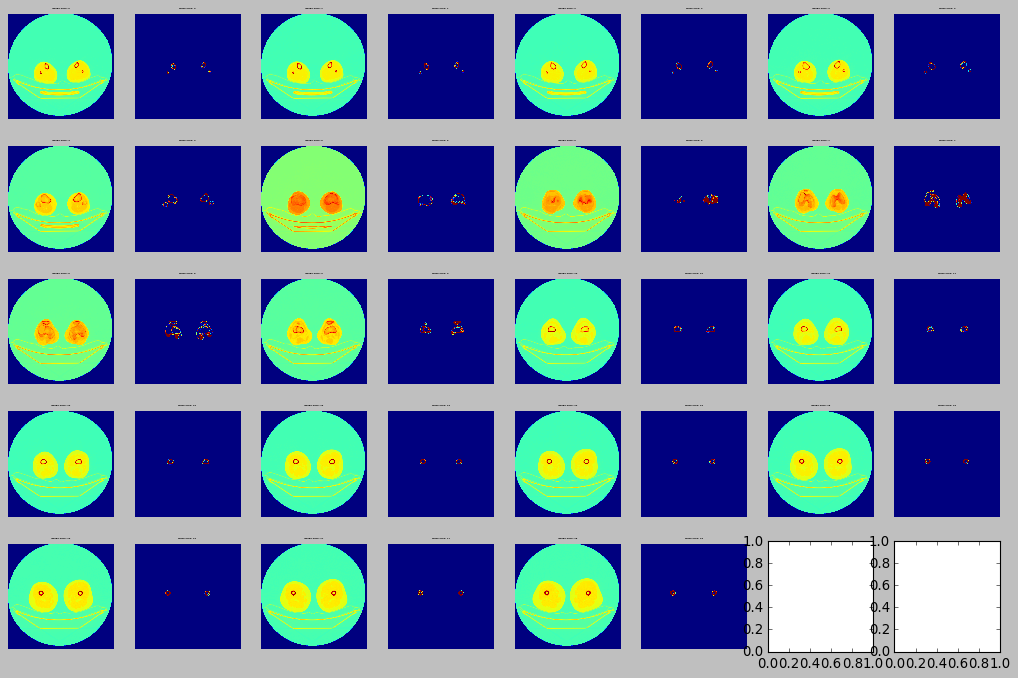

In [43]:
def plot(img3d, mask3d, view, num_images, rows, columns):
  # Determine step size
  
  if view == 'sagittal':
    slice_step = img3d.shape[2] // num_images
  elif view == 'coronal':
    slice_step = img3d.shape[1] // num_images
  elif view == 'axial':
    slice_step = img3d.shape[0] // num_images

  # Select subset of images
  selected_images = np.arange(0, img3d.shape[2], slice_step)[:num_images]

  # Double the number of columns to accommodate masks
  columns *= 2

  # Define figure size
  figsize = (16, 10)

  # Create subplot grid
  fig, axes = plt.subplots(rows, columns, figsize=figsize)

  # Plot selected images and masks in grid
  for i, ax in enumerate(axes.flatten()):
      if i < num_images:
        x = i // (columns // 2)
        y = i % (columns // 2)
        if view == 'sagittal':
          img = img3d[:, :, selected_images[i]]
          mask = mask3d[:, :, selected_images[i]]
        elif view == 'coronal':
          img = img3d[:, selected_images[i], :]
          mask = mask3d[:, selected_images[i], :]
        elif view == 'axial':
          img = img3d[selected_images[i], :, :]
          mask = mask3d[selected_images[i], :, :]
        axes[x, y*2].imshow(img)
        axes[x, y*2].set_title(f"Image Slice: {i}", fontsize=2, weight='bold')
        axes[x, y*2].axis('off')
        axes[x, y*2 + 1].imshow(mask)
        axes[x, y*2 + 1].set_title(f"Mask Slice: {i}", fontsize=2, weight='bold')
        axes[x, y*2 + 1].axis('off')
      else:
          ax.axis('off')

  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1) #no space
  plt.show()

# Running the code:
plot(sliceimage, slicemask, 'axial', 20, 5, 4)

Full Mask

In [ ]:
plt.style.use('dark_background')

#dcm_paths is slices from read_plot_dicom_mask function

class DrawMaskSample():
    def __init__(self, dcm_sample, i, ax):
        self.i = i
        self.ax = ax
        #self.dcm_sample = pydicom.dcmread(dcm_paths[self.i])
        self.dcm_sample = dcm_sample
        print(f'sample({i+1}) shape: {self.dcm_sample.shape}')
        self.get_xyz()
        self.draw_sample_3d()

    def get_xyz(self):
        self.xyz_li = []
        cnt = 0
        max_cnt = self.dcm_sample.shape[-1]
        for iter_z, (iter_img) in enumerate(self.dcm_sample.transpose(2,0,1)):
            for iter_x, iter_arr_y in enumerate(iter_img):
                iter_arr_y = np.where(iter_arr_y)[0]
                if len(iter_arr_y) >= 1:
                    iter_arr_y = list(set([iter_arr_y.max(), iter_arr_y.min()]))
                    xyz = [(iter_x, iter_y, iter_z) for iter_y in iter_arr_y if np.any(iter_y)]
                    self.xyz_li.append(xyz)
            cnt += 1
            if (cnt % 100 == 0) | (cnt == max_cnt):
                print(f'iteration: ({cnt} / {max_cnt})')

    def draw_sample_3d(self):
        xyz_matrix = np.array(list(chain.from_iterable(self.xyz_li)))
        X = xyz_matrix[:,0]
        Y = xyz_matrix[:,1]
        Z = xyz_matrix[:,2]

        self.ax.scatter(X, Y, Z, s=1, alpha=0.04, color='beige')
        xlim, ylim, zlim = self.dcm_sample.shape
        self.ax.set_xlim(0, xlim)
        self.ax.set_ylim(0, ylim)
        self.ax.set_zlim(0, zlim)
        self.ax.set_title(f'sample - ({self.i+1})')

In [ ]:
fig = plt.figure(figsize=(16,16))
for i in range(2):
    ax = fig.add_subplot(int(f'33{i+1}'), projection='3d')
    DrawMaskSample(slicemask, i, ax)

plt.tight_layout()
plt.show()

Interactive 3D model (with HU segmentation, not mask dataset)

In [ ]:
### Helper functions
def load_scan(path, reverse=True):
    slices = [pydicom.read_file(path + "/" + s) for s in os.listdir(path)]
    slices.sort(key=lambda x: int(x.InstanceNumber), reverse=reverse)

    try:
        slice_thickness = np.abs(
            slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2]
        )
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

    for s in slices:
        s.SliceThickness = slice_thickness

    return slices

In [ ]:
### Helper functions
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)
    image[image == -2000] = 0

    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope

    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)

    image += np.int16(intercept)
    return np.array(image, dtype=np.int16)

In [ ]:
### Helper functions
def resample(image, scan, new_spacing=[1, 1, 1]):
    spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor

    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    return image, new_spacing

In [ ]:
### Helper functions
def generate_surface(image, lower_bound = 700, upper_bound =3000, threshold=0.5, step_size=1):
    # Threshold the image
    thresholded_image = np.zeros_like(image)
    thresholded_image[(image >= lower_bound) & (image <= upper_bound)] = 1

    # Generate a surface using the marching cubes algorithm
    p = thresholded_image.transpose(2, 1, 0)
    verts, faces, _, _ = measure.marching_cubes(p, threshold, step_size=step_size, allow_degenerate=True)

    return verts, faces



In [ ]:
### Helper functions
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)
    counts = counts[vals != bg]
    vals = vals[vals != bg]
    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None


In [ ]:
### Helper functions
# def segment_bone_mask(image, fill_lung_structures=True):
#     binary_image = np.array(image >= -700, dtype=np.int8) + 1
#     labels = measure.label(binary_image)
#     background_label = labels[0, 0, 0]
#     binary_image[background_label == labels] = 2

#     if fill_lung_structures:
#         for i, axial_slice in enumerate(binary_image):
#             axial_slice = axial_slice - 1
#             labeling = measure.label(axial_slice)
#             l_max = largest_label_volume(labeling, bg=0)

#             if l_max is not None:
#                 binary_image[i][labeling != l_max] = 1
#     binary_image -= 1
#     binary_image = 1 - binary_image

#     labels = measure.label(binary_image, background=0)
#     l_max = largest_label_volume(labels, bg=0)
#     if l_max is not None:
#         binary_image[labels != l_max] = 0

#     return binary_image

Data Analysis

In [17]:
from glob import glob
TRAIN_DIR = "/Users/shinghimho/Desktop/programming/Deep_Learning_for_3D_Image_Segmentation/Kazakhstan_Dataset/Deidentified Scans/"
sub_folder_list = []
for x in os.listdir(TRAIN_DIR):
    if os.path.isdir(TRAIN_DIR + '/' + x):
        sub_folder_list.append(x)
n_dicom_dict = {"Patient":[],"n_dicom":[]}
for x in sub_folder_list:
    g = glob(TRAIN_DIR+x + '/*')
    n_dicom_dict["n_dicom"].append(len(g))
    n_dicom_dict["Patient"].append(x)
dicom_df = pd.DataFrame(n_dicom_dict)
dicom_df.sort_values(['n_dicom'], inplace=True)

Minimum number of dicom files: 481
Maximum number of dicom files: 1202


/var/folders/13/vxlxs5js5js9vr_s0v4gfzjh0000gn/T/ipykernel_65878/4149543475.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dicom_df['n_dicom'], bins=20, color="#a55eea")


Text(0.5, 1.0, 'Number of dicom files per patient')

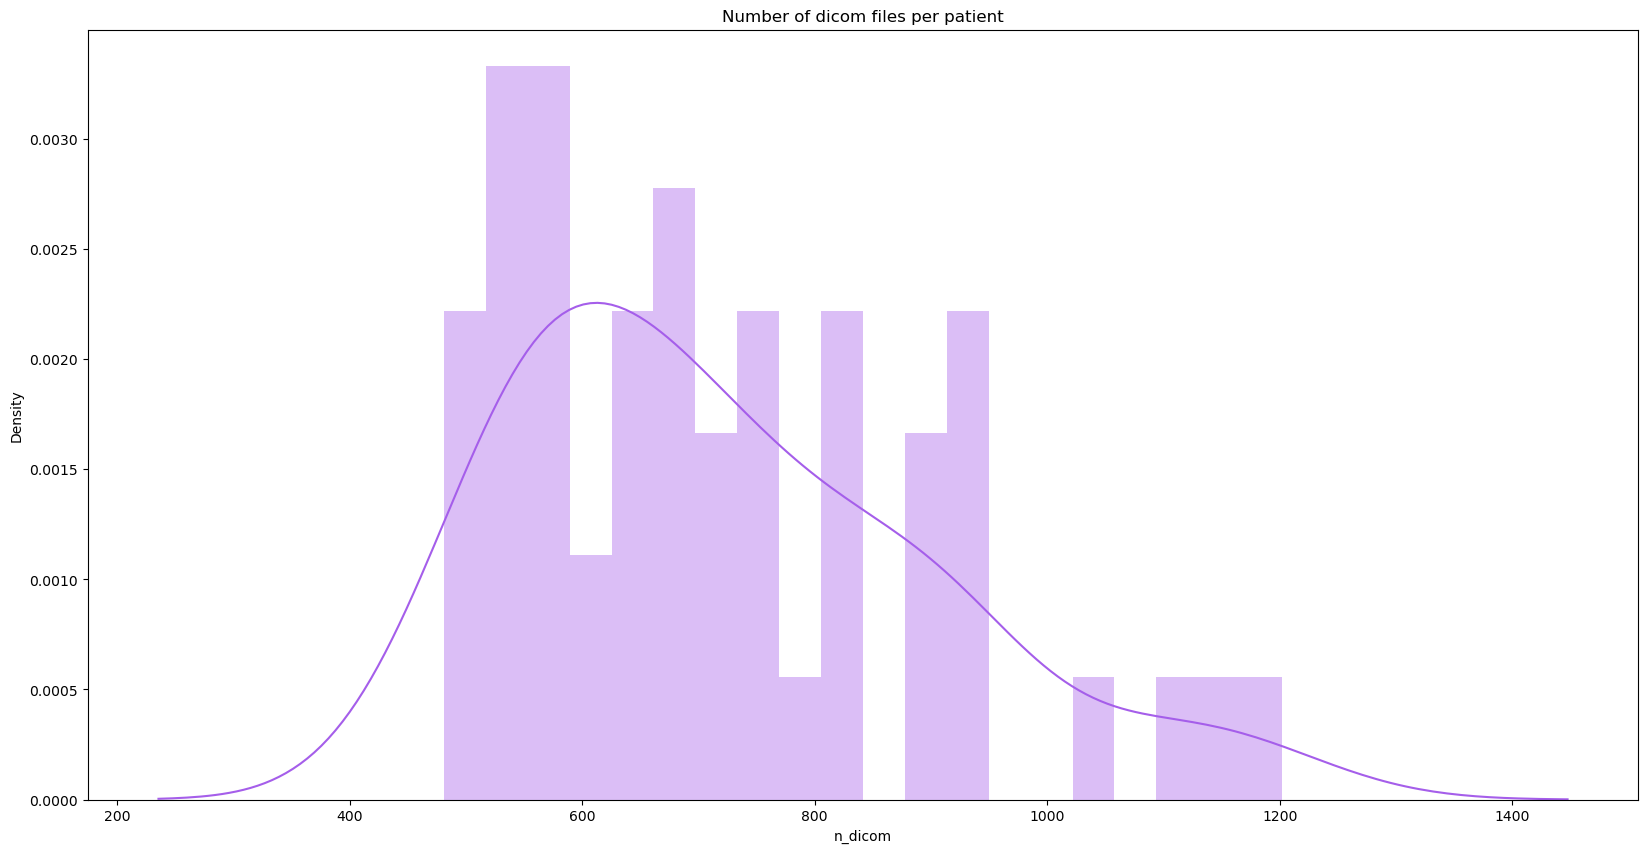

In [18]:
print("Minimum number of dicom files:", min(dicom_df['n_dicom']))
print("Maximum number of dicom files:", max(dicom_df['n_dicom']))

plt.figure(figsize=(20,10))
sns.distplot(dicom_df['n_dicom'], bins=20, color="#a55eea")
plt.title('Number of dicom files per patient')

In [19]:
available_styles = plt.style.available

# Print the list of available styles
print(available_styles)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


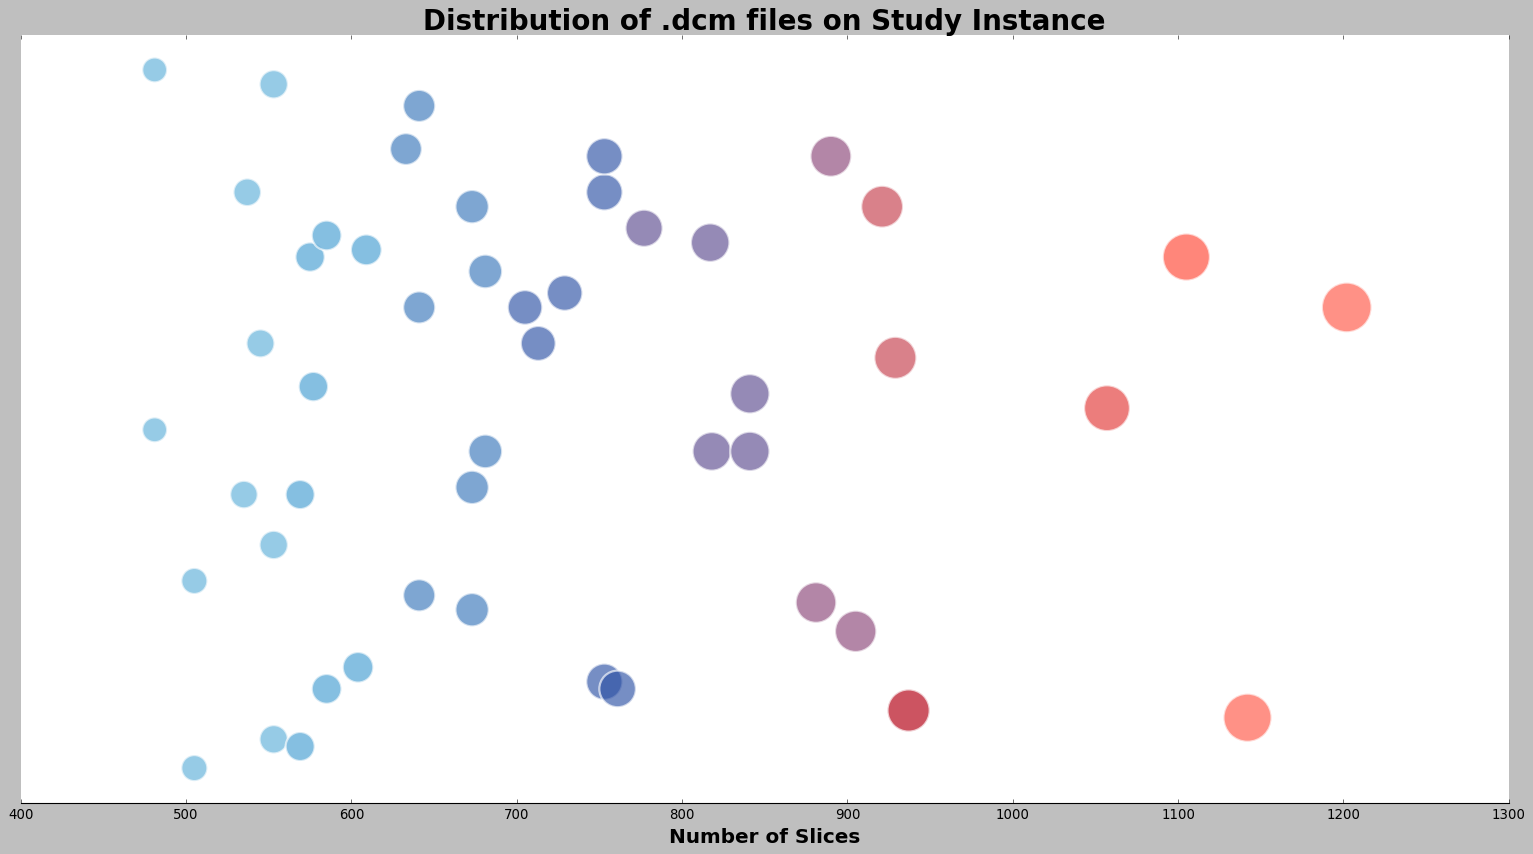

In [21]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import random
plt.style.use('classic')
class clr:
    S = '\033[1m' + '\033[94m'
    E = '\033[0m'
    
my_colors = ["#5EAFD9", "#449DD1", "#3977BB", 
             "#2D51A5", "#5C4C8F", "#8B4679",
             "#C53D4C", "#E23836", "#FF4633", "#FF5746"]
CMAP1 = ListedColormap(my_colors)
random.seed(25)

# Add a fictive y
# this "y" doesn't mean anything, it's just for
# showcasing purposes

dicom_df["y"] = [random.randint(0, 100) for i in range(len(dicom_df))]
perc = round(dicom_df[dicom_df["n_dicom"]<=10].shape[0]/len(dicom_df), 3)*100

plt.figure(figsize=(24, 12))
sns.scatterplot(data=dicom_df, x="n_dicom", y="y", size="n_dicom",alpha=0.65, sizes=(500, 2000),hue="n_dicom",palette=CMAP1)

plt.title("Distribution of .dcm files on Study Instance", weight="bold", size=25)
plt.xlabel("Number of Slices", size = 18, weight="bold")
plt.ylabel("")
plt.yticks([])

plt.legend('',frameon=False)
sns.despine(right=True, top=True, left=True)

# plt.axvline(x=200, linestyle = '--', color="black", lw=4)
# plt.axvline(x=400, linestyle = '--', color="black", lw=4)
# # plt.text(x=225, y=50, s=f"~80% of data is here", color="black", size=20, weight="bold")

# plt.axvline(x=600, linestyle = '--', color="black", lw=4)
# plt.text(x=610, y=7, s=f"only 50 instances with slices >=600", color="black", size=14, weight="bold")
# plt.arrow(x=600, y=5, dx=200, dy=0, color="black", lw=4, 
#           head_width=2, head_length=8)

In [ ]:
# Create column with full image size (height x width)
meta_train["ImageSize"] = meta_train["Rows"].astype(str) + " x " + meta_train["Columns"].astype(str)


# Plot
plt.figure(figsize=(24, 10))
axs = sns.countplot(data=meta_train, x="ImageSize", palette=my_colors[5:])
show_values_on_bars(axs, h_v="v", space=0.4)
plt.title("Frequency of Image Sizes in .dcm data", weight="bold", size=19)
plt.xlabel("Image Size (height x width)", size = 18, weight="bold")
plt.ylabel("")
plt.yticks([])

# Hatch
for i, bar in enumerate(axs.patches):
    hatch = ''
    if i==0:
        hatch = '/'
    bar.set_hatch(hatch)

# Arrow
style = "Simple, tail_width=2, head_width=14, head_length=16"
kw = dict(arrowstyle=style, color=my_colors[4])
arrow = patches.FancyArrowPatch((0.8, 300000), (0.2, 200000),
                             connectionstyle="arc3,rad=.10", **kw)
plt.gca().add_patch(arrow)
plt.text(x=0.8, y=300000, s=f"99.6% of images have size 512x512",
         color=my_colors[4], size=17, weight="bold")

plt.text(x=1, y=70000, s=f"The rest 0.32% should be resized too as 512x512",
         color=my_colors[6], size=17, weight="bold")
plt.axhline(xmin=0.4, xmax=0.95, y=60000, linestyle = '--', color=my_colors[6], lw=2)

sns.despine(right=True, top=True, left=True)

In [ ]:
from glob import glob
plt.style.use('dark_background')
data_path = "/Users/shinghimho/Desktop/programming/Deep_Learning_for_3D_Image_Segmentation/Kazakhstan Dataset/Deidentified Scans/CT26_1/"

In [ ]:
def plot_3d(data_path, reverse=False):
    
    print(f"{data_path.split('/')[-3].upper()} - {data_path.split('/')[-2]}")
    g = glob(data_path + "/*")
    print(f"Total of {len(g)} DICOM images.")

    patient = load_scan(data_path, reverse)
    print(f"Slice Thickness: {patient[0].SliceThickness}")
    print(f"Pixel Spacing (row, col): ({patient[0].PixelSpacing[0]}, {patient[0].PixelSpacing[1]})")

    imgs = get_pixels_hu(patient)
    print(f"Shape resampling: {imgs.shape}", end="")
    imgs_after_resamp, spacing = resample(imgs, patient, [1, 1, 1])
    print(f" -> {imgs_after_resamp.shape}")

    # Print min and max values of the volume data
    print(f"Min Value: {np.min(imgs_after_resamp)}")
    print(f"Max Value: {np.max(imgs_after_resamp)}")

    # Generate a histogram
    plt.hist(imgs_after_resamp.flatten(), bins=80, color='c')
    plt.xlabel("Hounsfield Units (HU)")
    plt.ylabel("Frequency")
    plt.show()

    histogram, bins = np.histogram(imgs_after_resamp.flatten(), bins=80)

    # Finding the bin with the maximum count
    max_index = np.argmax(histogram)
    max_bin = bins[max_index]
    print(max_bin)

    # Generate the surface using the combined function
    v1, f1 = generate_surface(imgs_after_resamp, lower_bound = 700, upper_bound = 3000, threshold=0.5, step_size=2)

    # segmented_lungs = segment_lung_mask(imgs_after_resamp, fill_lung_structures=False)
    # segmented_lungs_fill = segment_lung_mask(imgs_after_resamp, fill_lung_structures=True)
    # internal_structures = segmented_lungs_fill - segmented_lungs
    # p = internal_structures.transpose(2, 1, 0)
    # v2, f2, _, _ = measure.marching_cubes(p)
    
    ### PLOTS
    fig = plt.figure(figsize=(20, 10))
    bg = np.array((30, 39, 46))/255.0
    # Ext
    print(".", end="")
    x, y, z = zip(*v1)
    ax1 = fig.add_subplot(121, projection="3d")
    mesh = Poly3DCollection(v1[f1], alpha=0.8)
    face_color = (1, 1, 0.9)
    mesh.set_facecolor(face_color)
    ax1.add_collection3d(mesh)
    ax1.set_xlim(0, max(x))
    ax1.set_ylim(0, max(y))
    ax1.set_zlim(0, max(z))
    ax1.w_xaxis.set_pane_color((*bg, 1))
    ax1.w_yaxis.set_pane_color((*bg, 1))
    ax1.w_zaxis.set_pane_color((*bg, 1))

    # # Int
    # print(".", end="")
    # x, y, z = zip(*v2)
    # ax2 = fig.add_subplot(122, projection="3d")
    # mesh = Poly3DCollection(v2[f2], alpha=0.8)
    # face_color = np.array((255, 107, 107))/255.0
    # mesh.set_facecolor(face_color)
    # ax2.add_collection3d(mesh)
    # ax2.set_xlim(0, max(x))
    # ax2.set_ylim(0, max(y))
    # ax2.set_zlim(0, max(z))
    # ax2.w_xaxis.set_pane_color((*bg, 1))
    # ax2.w_yaxis.set_pane_color((*bg, 1))
    # ax2.w_zaxis.set_pane_color((*bg, 1))

    print(".", end="")
    fig.tight_layout()
    plt.show()

In [ ]:
plot_3d(data_path)

In [ ]:
### 3D interactive ploting helper
def plotly_3d(verts, faces, ext=True):
    x, y, z = zip(*verts)

    fig = create_trisurf(
        x=x,
        y=y,
        z=z,
        plot_edges=False,
        show_colorbar=False,
        showbackground=False,
        colormap=["rgb(236, 236, 212)", "rgb(236, 236, 212)"] if ext else ["rgb(255, 107, 107)", "rgb(255, 107, 107)"],
        simplices=faces,
        backgroundcolor="rgb(30, 39, 46)",
        gridcolor="rgb(30, 39, 46)",
        title="<b>Interactive Visualization</b>",
    )
    fig.layout.template = "plotly_dark"  # for dark theme
    fig.show()

In [ ]:
### Ploting functions


def plot3d_interactive_ext(data_path, reverse=False):
    print(f"{data_path.split('/')[-3].upper()} - {data_path.split('/')[-2]}")
    g = glob(data_path + "/*")
    patient = load_scan(data_path, reverse)
    imgs = get_pixels_hu(patient)
    imgs_after_resamp, spacing = resample(imgs, patient, [1, 1, 1])

    # Generate the surface using the combined function
    v, f = generate_surface(imgs_after_resamp, lower_bound=400, upper_bound=3000, threshold=0.5, step_size=2)
    plotly_3d(v, f)


# def plot3d_interactive_int(data_path, reverse=False):
#     print(f"{data_path.split('/')[-3].upper()} - {data_path.split('/')[-2]}")
#     g = glob(data_path + "/*")
#     patient = load_scan(data_path, reverse)
#     imgs = get_pixels_hu(patient)
#     imgs_after_resamp, spacing = resample(imgs, patient, [1, 1, 1])

#     segmented_lungs = segment_lung_mask(imgs_after_resamp, fill_lung_structures=False)
#     segmented_lungs_fill = segment_lung_mask(imgs_after_resamp, fill_lung_structures=True)
#     internal_structures = segmented_lungs_fill - segmented_lungs

#     p = internal_structures.transpose(2, 1, 0)
#     verts, faces, _, _ = measure.marching_cubes_lewiner(p)
#     plotly_3d(verts, faces, ext=False)

In [ ]:
plot3d_interactive_ext(data_path)